# **Imports**

In [ ]:
import pickle
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import scipy.misc
!pip install fancyimpute
import fancyimpute
!pip install mpi4py
from mpi4py import MPI
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
import math
import os

In [ ]:
import Toolbox
from Toolbox import two_d_eq, Assign_features_to_pixels, REFINED_Im_Gen

>>>> MDS


# **Initial_MDS funcion**

In [ ]:
def initial_mds(refined_dir, data):

  os.chdir(refined_dir)

  #%% Loading the data
  Feat_DF = pd.read_csv(data, sep=';')

  X = Feat_DF.values
  original_input = pd.DataFrame(data = X) # The MDS input should be in a dataframe format with rows as samples and columns as features
  feature_names_list = original_input.columns.tolist() # Extracting feature_names_list (gene_names or descriptor_names)
  print(">>>> Data  is loaded")

  #%% MDS
  nn = math.ceil(np.sqrt(len(feature_names_list))) # Image dimension
  Nn = original_input.shape[1] 										 # Number of features

  transposed_input = original_input.T # The MDS input data must be transposed , because we want summarize each feature by two values (as compard to regular dimensionality reduction each sample will be described by two values)
  Euc_Dist = euclidean_distances(transposed_input) # Euclidean distance
  Euc_Dist = np.maximum(Euc_Dist, Euc_Dist.transpose()) # Making the Euclidean distance matrix symmetric

  embedding = MDS(n_components=2, random_state=1701)	# Reduce the dimensionality by MDS into 2 components
  mds_xy = embedding.fit_transform(transposed_input)	# Apply MDS

  print(">>>> MDS dimensionality reduction is done")

  eq_xy = two_d_eq(mds_xy,Nn)
  Img = Assign_features_to_pixels(eq_xy,nn,verbose=1)					# Img is the none-overlapping coordinates generated by MDS

  #%% To be saved for hill climbing
  Desc = Feat_DF.columns.tolist()		# Drug descriptors name
  Dist = pd.DataFrame(data = Euc_Dist, columns = Desc, index = Desc)	# Generating a distance matrix which includes the Euclidean distance between each and every descriptor
  data = (Desc, Dist, Img	) # Preparing the hill climbing inputs

  with open("Init_MDS.pickle", 'wb') as f:	# The hill climbing input is a pickle, therefore everything is saved as a pickle to be loaded by the hill climbing
      pickle.dump(data, f)

  return nn, X

# **Congential Syphilis**

## Train

In [ ]:
# Check and delete temporary files
mds = 'REFINED/REFINED/Init_MDS.pickle'
mapping = 'REFINED/REFINED/Mapping_REFINED.pickle'
evolve = 'REFINED/REFINED/REFINED_Evolve.csv'

if os.path.isfile(mds): os.remove(mds)
if os.path.isfile(mapping): os.remove(mapping)
if os.path.isfile(evolve): os.remove(evolve)

In [ ]:
# Train

refined_dir = 'REFINED/REFINED/'
train = 'Tabular data sets/Syphilis/X_train.csv'

# Initial MDS
nn, X = initial_mds(refined_dir, train)

# Hill Climbing
!python3 'REFINED/REFINED/mpiHill_UF.py' --init 'Init_MDS.pickle' --mapping 'Mapping_REFINED.pickle' --evolution 'REFINED_Evolve.csv' --num 5

with open('Mapping_REFINED.pickle','rb') as file:
    gene_names_MDS, coords_MDS, map_in_int_MDS = pickle.load(file)

X_REFINED_MDS = REFINED_Im_Gen(X, nn, map_in_int_MDS, gene_names_MDS, coords_MDS)

with open('REFINED/data/Cong_Syphilis/X_train.pickle', 'wb') as file:
  pickle.dump(X_REFINED_MDS, file)


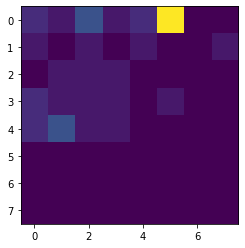

In [ ]:
img = np.expand_dims(X_REFINED_MDS, axis=2)
img = np.reshape(X_REFINED_MDS, (X_REFINED_MDS.shape[0], 8, 8, 1))
plt.imshow(np.reshape(X_REFINED_MDS[0], (8, 8)))

In [ ]:
dir = 'Tabular data sets/Syphilis/y_train.csv'
y_train = pd.read_csv(dir, sep=';')

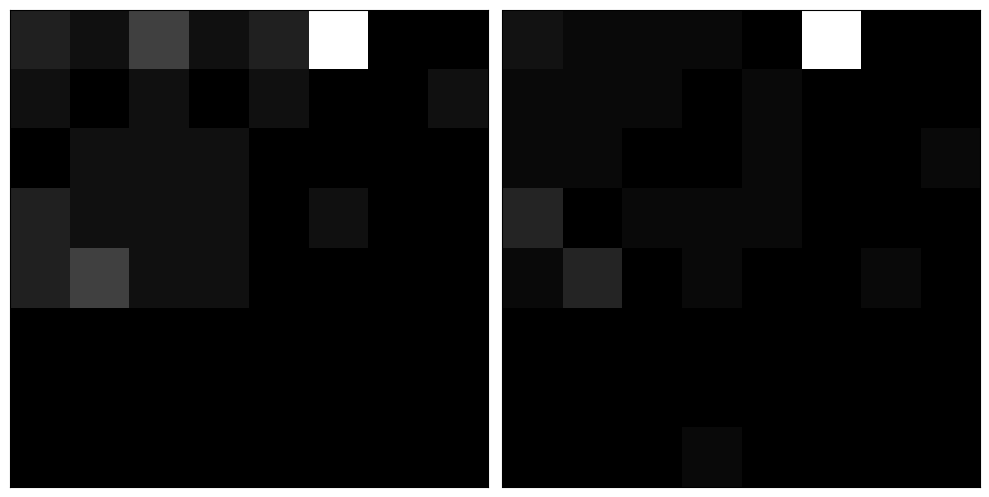

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

dir = 'Conversores/REFINED/data/Cong_Syphilis/X_train.pickle'

# Load the data from the pickle file
with open(dir, 'rb') as f:
    data = pickle.load(f)

# Extract the two images you want to plot
image1 = data[0]
image2 = data[1]

# Reshape the images if needed
image1 = np.reshape(image1, (8, 8))  # Replace height and width with the actual dimensions of your image
image2 = np.reshape(image2, (8, 8))  # Replace height and width with the actual dimensions of your image

# Plot the two images
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(image1, cmap='gray')
#ax[0].set_xlabel("Label: {}".format(y_train.iloc[1]))
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(image2, cmap='gray')
#ax[1].set_xlabel("Label: {}".format(y_train.iloc[2]))
ax[1].set_xticks([])
ax[1].set_yticks([])

plt.tight_layout()
plt.show()

## Test

In [ ]:
# Check and delete temporary files
mds = 'REFINED/REFINED/Init_MDS.pickle'
mapping = 'REFINED/REFINED/Mapping_REFINED.pickle'
evolve = 'REFINED/REFINED/REFINED_Evolve.csv'

if os.path.isfile(mds): os.remove(mds)
if os.path.isfile(mapping): os.remove(mapping)
if os.path.isfile(evolve): os.remove(evolve)

In [ ]:
# Train

refined_dir = 'REFINED/REFINED/'
train = 'Tabular data sets/Syphilis/X_test.csv'

# Initial MDS
nn, X = initial_mds(refined_dir, train)

# Hill Climbing
!python3 'REFINED/REFINED/mpiHill_UF.py' --init 'Init_MDS.pickle' --mapping 'Mapping_REFINED.pickle' --evolution 'REFINED_Evolve.csv' --num 5

with open('Mapping_REFINED.pickle','rb') as file:
    gene_names_MDS, coords_MDS, map_in_int_MDS = pickle.load(file)

# We pick the first 100 data points because of computational costs, but you can pick the entire datasets.
X_REFINED_MDS = REFINED_Im_Gen(X, nn, map_in_int_MDS, gene_names_MDS, coords_MDS)

with open('REFINED/data/Cong_Syphilis/X_test.pickle', 'wb') as file:
  pickle.dump(X_REFINED_MDS, file)


>>>> Data  is loaded
>>>> MDS dimensionality reduction is done
>> Assign features to pixels: 41 / 61
>> Assign features to pixels: 53 / 61
>> Assign features to pixels: 56 / 61
>> Assign features to pixels: 60 / 61
>> Assign features to pixels: 61 / 61
Processors found:  1
Time now at the beginning is:  2022-12-14 14:27:01.822675
Initial corr: >>> [0.98109351]
{}
> (0, 0) Corr: [0.98109351]
{}
> (0, 1) Corr: [0.98109351]
{}
> (0, 2) Corr: [0.98109351]
{}
> (1, 0) Corr: [0.98109351]
{}
> (1, 1) Corr: [0.98109351]
{}
> (1, 2) Corr: [0.98109351]
{}
> (2, 0) Corr: [0.98109351]
{}
> (2, 1) Corr: [0.98109351]
{}
> (2, 2) Corr: [0.98109351]
>>> 0 Corr: [0.98109351]
{}
> (0, 0) Corr: [0.98109351]
{}
> (0, 1) Corr: [0.98109351]
{}
> (0, 2) Corr: [0.98109351]
{}
> (1, 0) Corr: [0.98109351]
{}
> (1, 1) Corr: [0.98109351]
{}
> (1, 2) Corr: [0.98109351]
{}
> (2, 0) Corr: [0.98109351]
{}
> (2, 1) Corr: [0.98109351]
{}
> (2, 2) Corr: [0.98109351]
>>> 1 Corr: [0.98109351]
{}
> (0, 0) Corr: [0.98109351

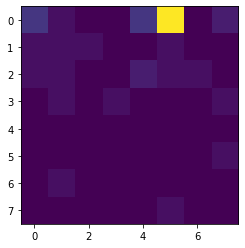

In [ ]:
img = np.expand_dims(X_REFINED_MDS, axis=2)
img = np.reshape(X_REFINED_MDS, (X_REFINED_MDS.shape[0], 8, 8, 1))
plt.imshow(np.reshape(X_REFINED_MDS[0], (8, 8)))